# Grama: Design Under Uncertainty

*Purpose*: We don't model uncertainty just for fun: Once we have a model for uncertainty we can use it to do useful work, such as informing design decisions. In this exercise you will model a particular kind of uncertainty in built systems (variability in part geometry) and use your models to make design decisions that are resilient against the effects of uncertainty.


## Setup


In [1]:
import grama as gr
import pandas as pd
DF = gr.Intention()
%matplotlib inline

# Uncertainty in Engineering Systems

The previous exercises `e-grama06-fit-univar` and `e-grama07-fit-multivar` covered the "how" and "why" of modeling uncertainties with distributions. In this exercise we'll study how uncertainty in the *inputs* of a model *propagates* to uncertainty in its outputs.


## Perturbed Design Variables

The realities of engineering manufacturing necessitate that built parts will be different from designed parts. In the previous exercise `e-grama07-fit-multivar` we saw a model for a circuit's performance. That system exhibited variability in its *realized component values*; we could pick the nominal (designed) component values `R, L, C`, but manufacturing variability would give rise to different as-made component values `Rr, Lr, Cr`.


In [2]:
from grama.models import make_prlc_rand
md_circuit = make_prlc_rand()


As a reminder, let's take a look at designed `C` and realized `Cr` values of the circuit capacitance.

In [3]:
# NOTE: No need to edit; run and inspect
(
    md_circuit
    >> gr.ev_sample(n=1e3, df_det="nom")
    
    >> gr.tf_summarize(
        C=gr.mean(DF.C),
        Cr_lo=gr.quant(DF.Cr, p=0.05),
        Cr_mu=gr.mean(DF.Cr),
        Cr_up=gr.quant(DF.Cr, p=0.95),
    )
)

eval_sample() is rounding n...


,C,Cr_lo,Cr_mu,Cr_up
0,50.0005,42.887234,64.404955,87.447509


The results above indicate that the designed capicitance was around `50`, but values as low as `42.2` and as high as `87.8` occur too.


### __q1__ Interpret the following density plot

The nominal value for `Design 1` is `x = 0.5`, while the nominal value for `Design 2` is `x = 1.5`. However, parts manufactured according to both designs are subject to manufacturing variability, as depicted by the following densities. Answer the questions under *observations* below.


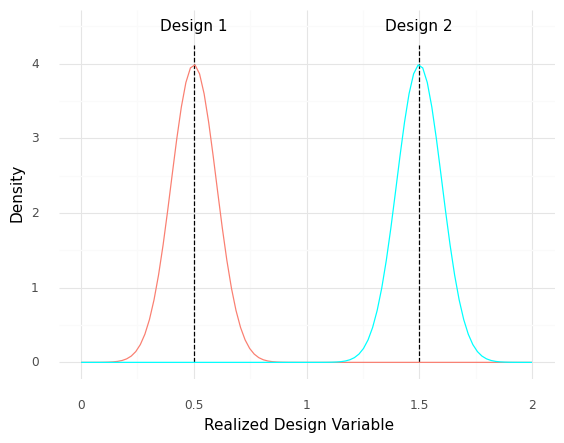

<ggplot: (8751230789843)>

In [4]:
mg_1 = gr.marg_mom("norm", mean=+0.5, sd=0.1)
mg_2 = gr.marg_mom("norm", mean=+1.5, sd=0.1)

(
    gr.df_make(x=gr.linspace(0, +2, 100))
    >> gr.tf_mutate(
        y_1=mg_1.d(DF.x),
        y_2=mg_2.d(DF.x),
    )
    
    >> gr.ggplot(gr.aes("x"))
    + gr.annotate("segment", x=+0.5, xend=+0.5, y=0, yend=4.25, linetype="dashed")
    + gr.annotate(
        "text",
        x=+0.5, y=4.5,
        label="Design 1",
    )
    + gr.annotate("segment", x=+1.5, xend=+1.5, y=0, yend=4.25, linetype="dashed")
    + gr.annotate(
        "text",
        x=+1.5, y=4.5,
        label="Design 2",
    )
    + gr.geom_line(gr.aes(y="y_1"), color="salmon")
    + gr.geom_line(gr.aes(y="y_2"), color="cyan")
    
    + gr.theme_minimal()
    + gr.labs(
        x="Realized Design Variable",
        y="Density"
    )
)

*Observations*

For the following questions, assume that you can measure the Realized Design Variable `x` with *perfect* accuracy.

<!-- task-begin -->
- Suppose you have a part with `x == 0.61`. Which design specification was this most likely manufactured according to?
  - (Your response here)
- Suppose you selected a random part of `Design 2` off the manufacturing line and found that `x == 1.40`. Would you be surprised by this?
  - (Your response here)
<!-- task-end -->
<!-- solution-begin -->
- Suppose you have a part with `x == 0.61`. Which design specification was this most likely manufactured according to?
  - `Design 1`
- Suppose you selected a random part of `Design 2` off the manufacturing line and found that `x == 1.40`. Would you be surprised by this?
  - Unsurprising; we can see that `x == 1.40` is well-within the distribution around the nominal `Design 2` value.
<!-- solution-end -->

### __q2__ Set up a perturbation model

Implement a model for a perturbed design variable $x_r$ following

$$x_r = x + \Delta x$$

where $\Delta x$ is normally distributed with mean $\mu = 0$ and standard deviation $\sigma = 0.1$.

*Hint 1*: To do this, you'll need to add a function to the model that computes $x_r$, and a random variable for $\Delta x$.

*Hint 2*: The previous exercises `e-grama06-fit-univar` and `e-grama07-fit-multivar` cover how to model an uncertain quantity.


In [5]:
## TASK: Implement the model for x_r stated above

md_dx = (
    gr.Model("Perturbation")
    >> gr.cp_vec_function(
# task-begin
        ## TODO: Implement a function for the perturbation
# task-end
# solution-begin
        fun=lambda df: gr.df_make(
            x_r=df.x + df.dx,
        ),
# solution-end
        var=["x", "dx"],
        out=["x_r"],
    )
    >> gr.cp_bounds(x=(-1, +1))
# task-begin
    ## TODO: Use compositions to model the uncertainty of dx
# task-end
# solution-begin
    >> gr.cp_marginals(
        dx=gr.marg_mom("norm", mean=0, sd=0.1),
    )
    >> gr.cp_copula_independence()
# solution-end
)

## NOTE: Use this to check your work
gr.eval_sample(md_dx, n=1, df_det="nom")
    
assert \
    'dx' in md_dx.density.marginals.keys(), \
    'No density for dx'
assert \
    md_dx.density.marginals['dx'].d_param['loc'] == 0., \
    "Density for dx has wrong mean"
assert \
    md_dx.density.marginals['dx'].d_param['scale'] == 0.1, \
    "Density for dx has wrong standard deviation"
    

## Uncertainty Propagation

Often, we model engineering outcomes *deterministically*; assuming certain inputs $x$ are known exactly, we produce a predictable output value $y$ based on a mathematical model $y = f(x)$.

For example, we've previously looked at a model for the buckling strength of a rectangular plate

$$\sigma_{cr} = k_{cr} \frac{\pi^2 E}{12 (1 - \mu^2)} \left(\frac{t}{b}\right)^2.$$

This is a *deterministic* model for the buckling strength $\sigma_{cr}$ that depends on the plate geometry, such as the plate thickness $t$.


However, if the input values cannot be controlled exactly, it may be more appropriate to think of the model as having *perturbed* inputs $x_r = x + \Delta x$. With perturbed inputs, the output is no longer precisely known, but is now subject to *uncertainty propagation*. We can think of this mathematically as 

$$y(x) = f(x_r) = f(x + \Delta x).$$

Where the input that the function "sees" is the perturbed input, rather than the deterministic input. This leads to uncertainty in the output $y$---the uncertainty *propagates* from the input to the output.

Returning to the buckling strength example, if there were manufacturing variability in the plate thickness $t_r = t + \Delta t$, then there would be uncertainty in the buckling strength

$$\sigma_{cr} = k_{cr} \frac{\pi^2 E}{12 (1 - \mu^2)} \left(\frac{t + \Delta t}{b}\right)^2.$$


The following images depict uncertainty propagation schematically. First, let's look at a linear function $f(x)$.

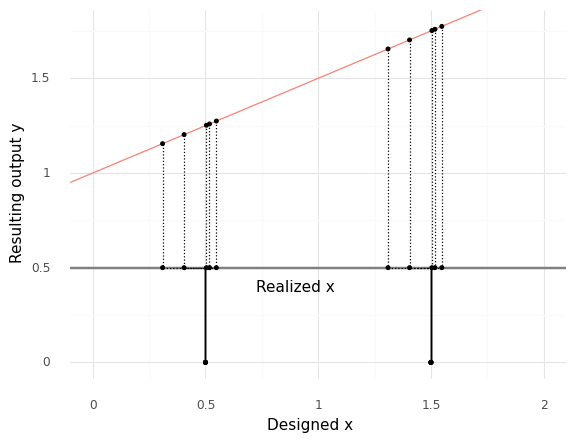

<ggplot: (8751231254218)>

In [6]:
# NOTE: No need to edit; this illustrates uncertainty propagation
md_line = (
    md_dx
    >> gr.cp_vec_function(
        fun=lambda df: gr.df_make(y=0.5*df.x_r + 1),
        var=["x_r"],
        out=["y"],
    )
)

y_baseboard = 0.5

(
    md_line
    >> gr.ev_sample(
        n=5,
        df_det=gr.df_make(x=(0.5, 1.5)),
        seed=101,
    )
    
    >> gr.ggplot(gr.aes("x_r", "y"))
    + gr.geom_hline(yintercept=y_baseboard, color="grey", size=1)
    + gr.geom_abline(intercept=1, slope=0.5, color="salmon")
    
    + gr.geom_segment(gr.aes(xend="x_r", yend=y_baseboard), linetype="dotted")
    + gr.geom_segment(gr.aes(xend="x", y=y_baseboard, yend=y_baseboard), linetype="dotted")
    + gr.geom_segment(gr.aes(x="x", xend="x", y=0, yend=y_baseboard))
    + gr.geom_point(size=1)
    + gr.geom_point(gr.aes(y=y_baseboard), size=1)
    + gr.geom_point(gr.aes(x="x", y=0), size=1)
    + gr.annotate(
        "text",
        x=0.9,
        y=y_baseboard-0.1,
        label="Realized x",
    )
    
    + gr.scale_x_continuous(limits=(0, 2))
    + gr.theme_minimal()
    + gr.labs(
        x="Designed x",
        y="Resulting output y",
    )
)

Here we have designed values of $x$ at $x = 0.5$ and $x = 1.5$. However, perturbations lead to variability in the realized values $x_r$, which in turn lead to variability in the output $y$.

The variability in $y$ is roughly the same at both designed values $x$. However, a different function can lead to quite different results.


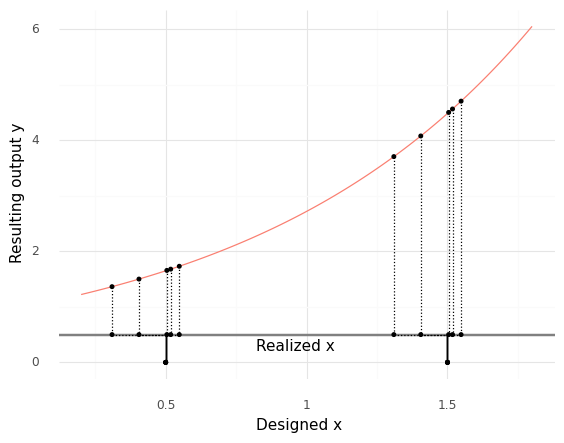

<ggplot: (8751230774492)>

In [7]:
# NOTE: No need to edit; this illustrates uncertainty propagation
md_exp = (
    md_dx
    >> gr.cp_vec_function(
        fun=lambda df: gr.df_make(y=gr.exp(df.x_r)),
        var=["x_r"],
        out=["y"],
    )
)

y_baseboard = 0.5

(
    md_exp
    >> gr.ev_sample(
        n=5,
        df_det=gr.df_make(x=(0.5, 1.5)),
        seed=101,
    )
    
    >> gr.ggplot(gr.aes("x_r", "y"))
    + gr.geom_hline(yintercept=y_baseboard, color="grey", size=1)
    + gr.geom_line(
        data=md_exp
        >> gr.ev_nominal(df_det=gr.df_make(x=gr.linspace(0.2, 1.8, 100))),
        mapping=gr.aes("x"),
        color="salmon",
    )
    
    + gr.geom_segment(gr.aes(xend="x_r", yend=y_baseboard), linetype="dotted")
    + gr.geom_segment(gr.aes(xend="x", y=y_baseboard, yend=y_baseboard), linetype="dotted")
    + gr.geom_segment(gr.aes(x="x", xend="x", y=0, yend=y_baseboard))
    + gr.geom_point(size=1)
    + gr.geom_point(gr.aes(y=y_baseboard), size=1)
    + gr.geom_point(gr.aes(x="x", y=0), size=1)
    + gr.annotate(
        "text",
        x=0.96,
        y=y_baseboard-0.2,
        label="Realized x",
    )
    
    + gr.theme_minimal()
    + gr.labs(
        x="Designed x",
        y="Resulting output y",
    )
)

Once again we see variability in the realized values. However, note that the variability in the realized output `y` 


### __q3__ Do a sweep with propagated uncertainty

Use your perturbation model `md_dx` to study how variability propagates through the function

$$y(x) = f(x_r) = x_r^4.$$

Sweep the design variable $x$ from at least $0.1$ to $1.0$, and make sure to use a sufficient number of observations in your random sample. Answer the questions under *observations* below.


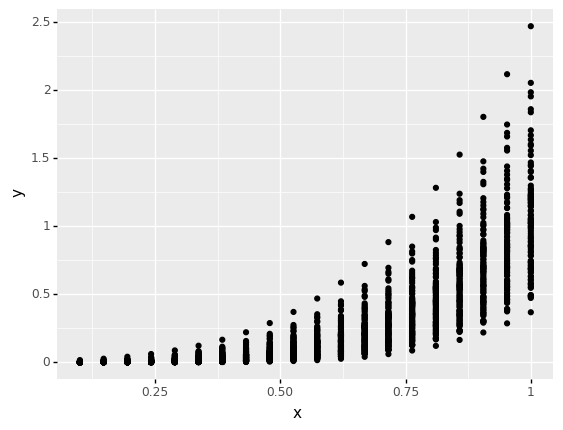

<ggplot: (8751231026707)>

In [8]:
## TASK: Evaluate a sweep with with propagated uncertainty
df_dx = (
    md_dx
    # NOTE: No need to edit; this composes the output function
    # with the perturbation model you implemented above
    >> gr.cp_vec_function(
        fun=lambda df: gr.df_make(y=df.x_r**4),
        var=["x_r"],
        out=["y"],
    )
    
# task-begin
    ## TODO: Evaluate a random sample
# task-end
# solution-begin
    >> gr.ev_sample(
        n=100,
        df_det=gr.df_make(x=gr.linspace(0.1, 1.0, 20)),
    )
# solution-end
)

## NOTE: Use this to check your work
assert \
    isinstance(df_dx, pd.DataFrame), \
    "df_dx is not a DataFrame; make sure to evaluate md_dx"
assert \
    df_dx.x.min() <= 0.1, \
    "Make sure to sweep to a value as low as x == 0.1"
assert \
    df_dx.x.max() >= 1.0, \
    "Make sure to sweep to a value as high as x == 1.0"
assert \
    len(set(df_dx.x)) >= 10, \
    "Make sure to use a sufficient number of points in your sweep"
assert \
    len(set(df_dx.dx)) >= 100, \
    "Make sure to use a sufficient number of points in your sample"

# Visualize
(
    df_dx
    >> gr.ggplot(gr.aes("x", "y"))
    + gr.geom_point()
)

*Observations*

<!-- task-begin -->
- What does the horizontal axis in the plot above represent: The designed value of `x` or the realized value of `x`?
  - (Your response here)
- Why is there variability in `y`?
  - (Your response here)
- Where (along the horizontal axis) is the variability in `y` large? Where is it small?
  - (Your response here)
- What about the underlying function `y = f(x)` explains the trends in variability you noted above?
  - (Your response here)
<!-- task-end -->
<!-- solution-begin -->
- What does the horizontal axis in the plot above represent: The designed value of `x` or the realized value of `x`?
  - The horizontal axis in the plot above represents the designed value of `x`.
- Why is there variability in `y`?
  - There is variability in `y` because we are visualizing the designed value of `x`, while the realized value `x_r` varies randomly.
- Where (along the horizontal axis) is the variability in `y` large? Where is it small?
  - The variability is smallest at small values of $x$, and largest at large values of $x$.
- What about the underlying function `y = f(x)` explains the trends in variability you noted above?
  - Since the function is $y = x_r^4$, variability in $x_r$ is amplified by the function. A highly quantitative way to think of this is in terms of the derivative $\frac{dy}{dx_r} = 4 x_r^3 = 4 (x + \Delta x)^3$; note that larger values of the designed value lead to a larger slope in $y$. (I don't necessarily expect you to come up with that argument on your own!)
<!-- solution-end -->

## Summarizing variability

Visualizing variability with a scatterplot is a good first-step, but there are more effective ways to *summarize* variability.


### __q4__ Summarize variability across a sweep

Summarize the variability in $y$ at each value of $x$ by computing the mean `y_mu`, the 5% quantile `y_lo`, and the 95% quantile `y_up`. Answer the questions under *observations* below.


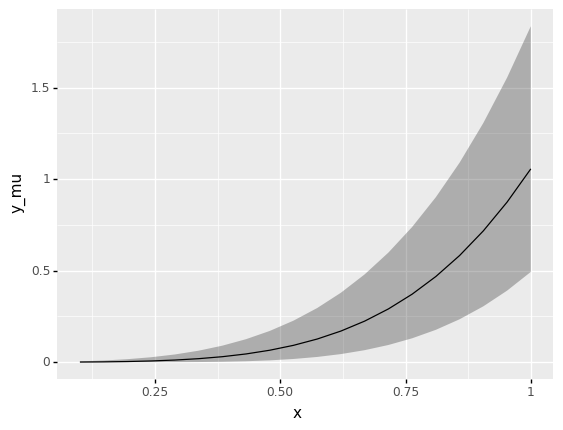

<ggplot: (8751230919190)>

In [9]:
df_dx_summary = (
    df_dx
# task-begin
    ## TODO: Summarize the result value `y` at each value of the
    ## designed value `x`
# task-end
# solution-begin
    >> gr.tf_group_by(DF.x)
    >> gr.tf_summarize(
        y_lo=gr.quant(DF.y, p=0.05),
        y_mu=gr.mean(DF.y),
        y_up=gr.quant(DF.y, p=0.95),
    )
# solution-end
    ## NOTE: Clean up the grouping
    >> gr.tf_ungroup()
)

## NOTE: No need to edit; use this to check your work
assert \
    set(df_dx.x) == set(df_dx_summary.x), \
    "Incorrect grouping for df_dx_summary"
assert \
    "y_lo" in df_dx_summary.columns, \
    "Make sure to compute a lower quantile y_lo"
assert \
    "y_up" in df_dx_summary.columns, \
    "Make sure to compute an upper quantile y_up"
# Check the quantiles
df_dx_check = (
    df_dx
    >> gr.tf_left_join(df_dx_summary, by="x")
    >> gr.tf_filter(DF.x == gr.min(DF.x))
    >> gr.tf_summarize(
        p_lo=gr.pr(DF.y <= DF.y_lo),
        p_up=gr.pr(DF.y <= DF.y_up),
    )
)
assert \
    abs(df_dx_check.p_lo[0] - 0.05) < 1e-3, \
    "Lower quantile value is incorrect"
assert \
    abs(df_dx_check.p_up[0] - 0.95) < 1e-3, \
    "Upper quantile value is incorrect"

(
    df_dx_summary
    >> gr.ggplot(gr.aes("x"))
    + gr.geom_ribbon(
        mapping=gr.aes(ymin="y_lo", ymax="y_up"),
        alpha=1/3,
    )
    + gr.geom_line(gr.aes(y="y_mu"))
)

*Observations*

*Note*: This plot uses `geom_ribbon()`, which takes the aesthetics `ymin` and `ymax`. A ribbon is a useful way to visualize a region bounded by lower and upper values, such as quantiles!

<!-- task-begin -->
- Contrast this plot with the scatterplot from q3: What can you see in this ribbon plot that is harder to see in the scatterplot?
  - (Your response here)
<!-- task-end -->
<!-- solution-begin -->
- Contrast this plot with the scatterplot from q3: What can you see in this ribbon plot that is harder to see in the scatterplot?
  - Some examples: We can see the mean trend quite clearly, while the mean trend is harder to judge by eye in the scatterplot. We can also see particular quantiles; if we wanted to make decisions based on the middle 90% of the data, these would be ideal bounds to use. If we wanted to use a different fraction of the data (say, 99%) we could adjust the quantiles (say, `0.005` and `0.995`).
<!-- solution-end -->


# Designing for uncertainty

We've seen that uncertainty can propagate through systems---what can we do about that? There are various ways we can design systems to mitigate the effects of uncertainty: We can seek *robust* designs, we can explicitly design for *reliability*, and we can *set tolerances* to achieve design targets.


## Robustness

Sometimes, the best nominal performance does not result in the overall "best" design. Since uncertainty can propagate, a design that is highly sensitive to input variability can fail to live up to the promise of its best nominal performance. The following example will guide you through thinking about designs that are *robust*, in the sense that they are resistant to uncertainty.


In [10]:
## NOTE: No need to edit; this sets up a model with
## a perturbed input and a complex output function
md_poly = (
    gr.Model("Polynomial")
    >> gr.cp_vec_function(
        fun=lambda df: gr.df_make(
            x_r=df.x + df.dx
        ),
        var=["x", "dx"],
        out=["x_r"],
        name="Realized design"
    )
    >> gr.cp_vec_function(
        fun=lambda df: gr.df_make(
            y=(df.x_r + 0.6) 
             *(df.x_r + 0.4) 
             *(df.x_r - 0.65)
             *(df.x_r - 0.55)
             *13.5 * (1 + gr.exp(8.0 * df.x_r))
        ),
        var=["x_r"],
        out=["y"],
        name="Realized output"
    )
    >> gr.cp_bounds(x=(-1, +1))
    >> gr.cp_marginals(dx=gr.marg_mom("norm", mean=0, sd=0.03))
    >> gr.cp_copula_independence()
)

### __q5__ Interpret this plot

Run the following code and inspect the plot. Answer the questions under *observations* below.


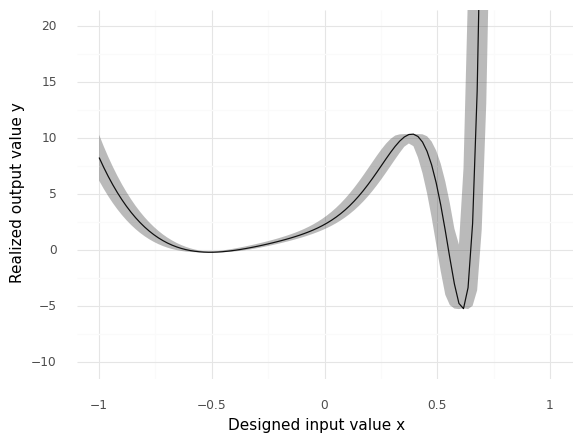

<ggplot: (8751230981578)>

In [11]:
## NOTE: No need to edit; run and inspect
# Evaluate model without uncertainty
df_poly_nom = (
    md_poly
    >> gr.ev_nominal(
        df_det=gr.df_make(x=gr.linspace(-1, +1, 100)),
    )
)

# Evaluate with uncertainty, take quantiles
df_poly_mc = (
    md_poly
    >> gr.ev_sample(
        df_det=gr.df_make(x=gr.linspace(-1, +1, 100)),
        n=40,
        seed=101,
    )
    >> gr.tf_group_by("x")
    >> gr.tf_summarize(
        y_lo=gr.quant(DF.y, p=0.05),
        y_mu=gr.median(DF.y),
        y_up=gr.quant(DF.y, p=0.95),
    )
    >> gr.tf_ungroup()
)

# Visualize
(
    df_poly_mc
    >> gr.tf_mutate(source="Quantiles")
    >> gr.ggplot(gr.aes("x"))
    + gr.geom_line(
        data=df_poly_nom
        >> gr.tf_mutate(source="Nominal"),
        mapping=gr.aes(y="y"),
    )
    + gr.geom_ribbon(
        mapping=gr.aes(ymin="y_lo", ymax="y_up"),
        alpha=1/3,
    )
    
    + gr.scale_y_continuous(breaks=(-10, -5, 0, +5, +10, +15, +20))
    + gr.coord_cartesian(ylim=(-10, 20))
    + gr.theme_minimal()
    + gr.guides(color=None)
    + gr.labs(
        x="Designed input value x",
        y="Realized output value y",
    )
)

*Observations*

For this example, *lower* values of `y` are better. The solid curve depicts the `Nominal` output value, while the shaded region visualizes the 5% to 95% quantiles.

<!-- task-begin -->
- *Approximately*, what is the lowest value `y` value the `Nominal` curve (solid curve) achieves across the values of `x` depicted above?
  - (Your response here)
- *Approimately*, what is the value of `y` for the `Nominal` curve at `x = -0.5`?
  - (Your response here)
- Note the spread between the `Quantiles` at $x \approx 0.6$. *Approximately* what range of `y` values would you expect to result from releated manufacturing at $x \approx 0.6$?
  - (Your response here)
- Note the spread between the `Quantiles` at $x \approx -0.5$. *Approximately* what range of `y` values would you expect to result from releated manufacturing at $x \approx -0.5$?
  - (Your response here)
- Suppose you plan to manufacture many parts according to this process, test all specimens, and choose the 5%. Which design (value of `x`) would you pick, and why?
  - (Your response here)
- Suppose you plan to manufacture many parts according to this process, all of which must work at an acceptable level. Which design (value of `x`) would you pick, and why?
  - (Your response here)
<!-- task-end -->
<!-- solution-begin -->
- *Approximately*, what is the lowest value `y` value the `Nominal` curve (solid curve) achieves across the values of `x` depicted above?
  - $y_{\min} \approx -5$
- *Approimately*, what is the value of `y` for the `Nominal` curve at `x = -0.5`?
  - $y(x = -0.5) \approx 0$
- Note the spread between the `Quantiles` at $x \approx 0.6$. *Approximately* what range of `y` values would you expect to result from releated manufacturing at $x \approx 0.6$?
  - $y \in [-5, 1]$
- Note the spread between the `Quantiles` at $x \approx -0.5$. *Approximately* what range of `y` values would you expect to result from releated manufacturing at $x \approx -0.5$?
  - $y \in [0, 0]$
- Suppose you plan to manufacture many parts according to this process, test all specimens, and choose the best 5%. Which design (value of `x`) would you pick, and why?
  - I would choose $x = 0.6$ for the design, as we would likely see a large number of highly negative (desirable) values. Post-manufacturing selection would allow us to collect a subset of highly-performing specimens.
- Suppose you plan to manufacture many parts according to this process, all of which must work at an acceptable level. Which design (value of `x`) would you pick, and why?
  - I would choose $x = -0.5$ for the design, as we need the performance of the parts to be consistent.
<!-- solution-end -->

## Reliability

While *robustness* is about reducing variability, *reliability* is about avoiding unwanted failures. A *reliable* design is a design that has a low probability of failure. With a model for a system and its uncertainties, we can use uncertainty propagation to quantify the probability of failure, and use the model to test the reliability of different designs.

For the remainder of this exercise, let's use the cantilever beam model as an example.


In [12]:
from grama.models import make_cantilever_beam
md_beam = make_cantilever_beam()
md_beam


model: Cantilever Beam

  inputs:
    var_det:
      w: [2, 4]
      t: [2, 4]

    var_rand:
      H: (+1) norm, {'mean': '5.000e+02', 's.d.': '1.000e+02', 'COV': 0.2, 'skew.': 0.0, 'kurt.': 3.0}
      V: (+1) norm, {'mean': '1.000e+03', 's.d.': '1.000e+02', 'COV': 0.1, 'skew.': 0.0, 'kurt.': 3.0}
      E: (+0) norm, {'mean': '2.900e+07', 's.d.': '1.450e+06', 'COV': 0.05, 'skew.': 0.0, 'kurt.': 3.0}
      Y: (-1) norm, {'mean': '4.000e+04', 's.d.': '2.000e+03', 'COV': 0.05, 'skew.': 0.0, 'kurt.': 3.0}

    copula:
      Independence copula

  functions:
      cross-sectional area: ['w', 't'] -> ['c_area']
      limit state: stress: ['w', 't', 'H', 'V', 'E', 'Y'] -> ['g_stress']
      limit state: displacement: ['w', 't', 'H', 'V', 'E', 'Y'] -> ['g_disp']

### __q6__ Compare the reliability of designs

Estimate the probability of failure due to `stress` for the following cantilever beam designs. Make sure to compute lower and upper confidence interval bounds for your estimate, and choose a large enough sample size so that the CI for the designs do not overlap. Answer the questions under *observations* below.

*Hint*: Remember that we learned about estimating probabilities of failure (and related confidence intervals) in `e-stat05-CI`.


In [13]:
## TASK: Estimate the reliability for the following beam designs

# NOTE: No need to edit; evaluate these designs
df_beam_designs = gr.df_make(
    design=["Wide", "Tall", "Square"],
    w=[4, 2, gr.sqrt(8)],
    t=[2, 4, gr.sqrt(8)],
)

## TASK: Complete the following code
df_beam_results = (
    md_beam
# task-begin
    ## TODO: Approximate the POF due to stress for each design.
    ## Make sure to provide a confidence interval as the columns [pof_lo, pof_up]
# task-end
# solution-begin
    >> gr.ev_sample(
        n=1e4, 
        df_det=df_beam_designs, 
        seed=101,
    )
    >> gr.tf_group_by(DF.design)
    >> gr.tf_summarize(
        pof_lo=gr.pr_lo(DF.g_stress <= 0),
        pof_mu=gr.pr(DF.g_stress <= 0),
        pof_up=gr.pr_up(DF.g_stress <= 0),
    )
    >> gr.tf_ungroup()
# solution-end
)

print(df_beam_results)

## NOTE: No need to edit below; use this to check your work
assert \
    isinstance(df_beam_results, pd.DataFrame), \
    "df_beam_results is not a DataFrame; make sure to evaluate and summarize"
assert \
    {"Square", "Tall", "Wide"} == set(df_beam_results.design), \
    "df_beam_results does not contain rows for each design; make sure to group appropriately"
assert \
    "pof_lo" in df_beam_results.columns, \
    "CI lower bound pof_lo not found in df_beam_results; make sure to compute a lower CI bound"
assert \
    "pof_up" in df_beam_results.columns, \
    "CI upper bound pof_up not found in df_beam_results; make sure to compute an upper CI bound"
assert \
    df_beam_results[df_beam_results.design=="Tall"].pof_up.values[0] < \
    df_beam_results[df_beam_results.design=="Square"].pof_lo.values[0], \
    "CI overlap; make sure to use a sufficiently large sample size"
assert \
    df_beam_results[df_beam_results.design=="Square"].pof_up.values[0] < \
    df_beam_results[df_beam_results.design=="Wide"].pof_lo.values[0], \
    "CI overlap; make sure to use a sufficiently large sample size"


eval_sample() is rounding n...
   design    pof_lo  pof_mu    pof_up
0  Square  0.473439  0.4863  0.499179
1    Tall  0.282503  0.2941  0.305970
2    Wide  0.928253  0.9349  0.940971


*Observations*

<!-- task-begin -->
- Which design has the lowest probability of failure?
  - (Your response here)
- All of these designs have the same cross-sectional area; they vary from wide to square to tall in their rectangular cross-section shape. Based on the result above, does width or tallness of the cross-section seem to be more important for safe operation?
  - (Your response here)
<!-- task-end -->
<!-- solution-begin -->
- Which design has the lowest probability of failure?
  - The `Tall` design has the lowest probability of failure.
- All of these designs have the same cross-sectional area; they vary from wide to square to tall in their rectangular cross-section shape. Based on the result above, does the *nominal* width or tallness of the cross-section seem to be more important for safe operation?
  - Tallness seems to be most important, based on these results.
<!-- solution-end -->

## Setting Tolerances

Once we represent uncertainty in a model, we can make modifications to that model to make quantitative statements about system performance. For instance, modeling the tolerances for a manufactured component will allow us to test different tolerance scenarios. This can help us decide whether to ask manufacturing to tighten specific tolerances.

The following code adds a perturbation model for tolerances on the width and tallness of the cantilever beam. You'll use this model below to test different tolerance scenarios.


In [14]:
## NOTE: NO need to edit; this adds tolerances to the cantilever beam model
md_beam_tolerances = (
    gr.Model()
    >> gr.cp_vec_function(
        fun=lambda df: gr.df_make(
            w=df.w0 + df.dw,
            t=df.t0 + df.dt,
        ),
        var=["w0", "t0", "dw", "dt"],
        out=["w", "t"],
        name="Design perturbations",
    )
    ## NOTE: gr.cp_md_det() is an advanced tool I'm using to
    ## avoid re-defining the entire beam model. You could
    ## accomplish the same thing with gr.cp_vec_function()
    ## and the beam equations
    >> gr.cp_md_det(md_beam)
    ## Define the input space
    >> gr.cp_bounds(
        w0=(2, 4),
        t0=(2, 4),
    )
    >> gr.cp_marginals(
        # Uncertainties from the original model
        H=gr.marg_mom("norm", mean=500, sd=100),
        V=gr.marg_mom("norm", mean=1000, sd=100),
        E=gr.marg_mom("norm", mean=2.9e7, sd=1.45e6),
        Y=gr.marg_mom("norm", mean=40000, sd=2000),
        # Variability in width and tallness
        dw=gr.marg_mom("uniform", mean=0, sd=1e-1),
        dt=gr.marg_mom("uniform", mean=0, sd=1e-1),
    )
    >> gr.cp_copula_independence()
)
md_beam_tolerances 


/home/zach/Git/py_grama/grama/marginals.py:336: RuntimeWarning: divide by zero encountered in double_scalars


model: None

  inputs:
    var_det:
      t0: [2, 4]
      w0: [2, 4]

    var_rand:
      H: (+0) norm, {'mean': '5.000e+02', 's.d.': '1.000e+02', 'COV': 0.2, 'skew.': 0.0, 'kurt.': 3.0}
      V: (+0) norm, {'mean': '1.000e+03', 's.d.': '1.000e+02', 'COV': 0.1, 'skew.': 0.0, 'kurt.': 3.0}
      E: (+0) norm, {'mean': '2.900e+07', 's.d.': '1.450e+06', 'COV': 0.05, 'skew.': 0.0, 'kurt.': 3.0}
      Y: (+0) norm, {'mean': '4.000e+04', 's.d.': '2.000e+03', 'COV': 0.05, 'skew.': 0.0, 'kurt.': 3.0}
      dw: (+0) uniform, {'mean': '0.000e+00', 's.d.': '1.000e-01', 'COV': inf, 'skew.': 0.0, 'kurt.': 1.8}
      dt: (+0) uniform, {'mean': '0.000e+00', 's.d.': '1.000e-01', 'COV': inf, 'skew.': 0.0, 'kurt.': 1.8}

    copula:
      Independence copula

  functions:
      Design perturbations: ['w0', 't0', 'dw', 'dt'] -> ['w', 't']
      Cantilever Beam: ['w', 'Y', 't', 'V', 'E', 'H'] -> ['c_area', 'g_stress', 'g_disp']

First, let's evaluate the baseline tolerance model to assess the probability of failure for a few designs.


In [15]:
## NOTE: No need to edit; this estimates probabilities of failure
## for the three designs
df_beam_baseline = (
    md_beam_tolerances
    >> gr.ev_sample(
        n=1e4, 
        df_det=gr.df_make(
            design=["Wide", "Tall", "Square"],
            w0=[4, 2, gr.sqrt(8)],
            t0=[2, 4, gr.sqrt(8)],
        ), 
        seed=101,
    )
    >> gr.tf_group_by(DF.design)
    >> gr.tf_summarize(
        pof_lo=gr.pr_lo(DF.g_stress <= 0),
        pof_mu=gr.pr(DF.g_stress <= 0),
        pof_up=gr.pr_up(DF.g_stress <= 0),
    )
    >> gr.tf_ungroup()
    >> gr.tf_mutate(model="Baseline")
)
df_beam_baseline


eval_sample() is rounding n...


,design,pof_lo,pof_mu,pof_up,model
0,Square,0.479931,0.4928,0.505678,Baseline
1,Tall,0.325530,0.3376,0.349885,Baseline
2,Wide,0.868392,0.8771,0.885308,Baseline


### __q7__ Recommend reasonable tolerances

Adjust the manufacturing tolerances to find desirable manufacturing targets. Answer the questions under *observations* below.


eval_sample() is rounding n...


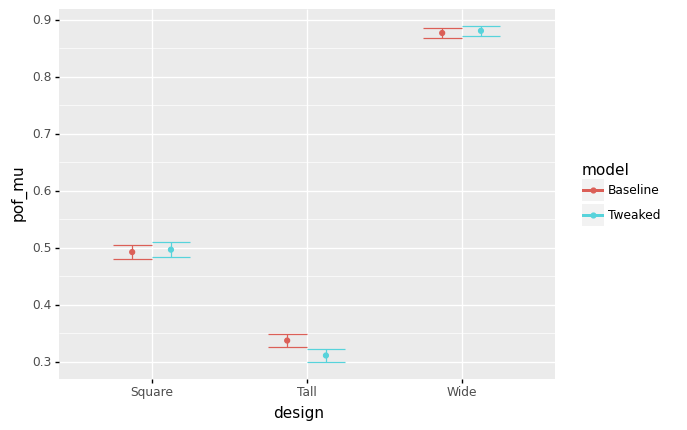

<ggplot: (8751231278427)>

In [16]:
## TASK: Tweak the tolerances

df_beam_tweaked = (
    md_beam_tolerances
    >> gr.cp_marginals(
# task-begin
        ## TODO: Override the marginals for dw and dt to test different 
        ## manufacturing tolerances
# task-end
# solution-begin
        dw=gr.marg_mom("uniform", mean=0, sd=1e-3), # Reduce width tolerance
#         dt=gr.marg_mom("uniform", mean=0, sd=1e-3), # Reduce tallness tolerance
# solution-end
    )
    ## NOTE: No need to edit below; this analyzes your model
    >> gr.ev_sample(
        n=1e4, 
        df_det=gr.df_make(
            design=["Wide", "Tall", "Square"],
            w0=[4, 2, gr.sqrt(8)],
            t0=[2, 4, gr.sqrt(8)],
        ), 
        seed=101,
    )
    >> gr.tf_group_by(DF.design)
    >> gr.tf_summarize(
        pof_lo=gr.pr_lo(DF.g_stress <= 0),
        pof_mu=gr.pr(DF.g_stress <= 0),
        pof_up=gr.pr_up(DF.g_stress <= 0),
    )
    >> gr.tf_ungroup()
    >> gr.tf_mutate(model="Tweaked")
)

## NOTE: This will visualize your results with
## a comparison against the baseline model
(
    df_beam_baseline
    >> gr.tf_bind_rows(df_beam_tweaked)
    >> gr.ggplot(gr.aes("design", color="model"))
    + gr.geom_errorbar(
        gr.aes(ymin="pof_lo", ymax="pof_up"),
        position=gr.position_dodge(width=0.5),
    )
    + gr.geom_point(
        gr.aes(y="pof_mu"), 
        position=gr.position_dodge(width=0.5),
    )
)


*Observations*

*Note*: It's likely you'll need to tweak and re-run the analysis above to answer these questions:

<!-- task-begin -->
- Suppose you could reduce the standard deviation `sd` to `1e-3` for both the width `dw` and tallness `dt` tolerances. Which designs would this benefit?
  - (Your response here)
- Consider the `Tall` design. Suppose it were only economical to reduce **one** of the tolerances: either for `dw` or `dt`. Which would be the more valuable tolerance to reduce?
  - (Your response here)
- In *q6 Compare the reliability of designs*, you answered the question "does the *nominal* width or tallness of the cross-section seem to be more important for safe operation?" How does your answer immediately above compare with your past answer?
  - (Your response here)
<!-- task-end -->
<!-- solution-begin -->
- Suppose you could reduce the standard deviation `sd` to `1e-3` for both the width `dw` and tallness `dt` tolerances. Which designs would this benefit?
  - Reducing the tolerances for both `dw` and `dt` would benefit the `Tall` design; it would significantly reduce the probability of failure. The same move would not benefit the `Square` design at all (the CI's overlap; no difference in their performance). Surprisingly, making the tolerances narrower would actually make the unsafe `Wide` design *even more likely to fail*.
- Consider the `Tall` design. Suppose it were only economical to reduce **one** of the tolerances: either for `dw` or `dt`. Which would be the more valuable tolerance to reduce?
  - Reducing the tolerance for `dw` is more valuable; in fact reducing the tolerance for `dt` does not result in a significant change for `pof_mu`.
- In *q6 Compare the reliability of designs*, you answered the question "does the *nominal* width or tallness of the cross-section seem to be more important for safe operation?" How does your answer immediately above compare with your past answer?
  - Surprisingly, the nominal thickness `t0` matters most for safe operation, but reducing the tolerance for `dw` most reduces the failure rate for the `Thick` design.
<!-- solution-end -->